# Classification des documents du procès des groupes américains du tabac

## Contexte

Le gouvernement américain a attaqué en justice cinq grands groupes américains du tabac pour avoir amassé d'importants bénéfices en mentant sur les dangers de la cigarette. Le cigarettiers  se sont entendus dès 1953, pour "mener ensemble une vaste campagne de relations publiques afin de contrer les preuves de plus en plus manifestes d'un lien entre la consommation de tabac et des maladies graves".

Dans ce procès 14 millions de documents ont été collectés et numérisés. Afin de faciliter l'exploitation de ces documents par les avocats, vous êtes en charge de mettre en place une classification automatique des types de documents.

## Import et chargement des données

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

np.random.seed(0)

In [2]:
paths = pd.read_csv('./tobacco_data/Tobacco3482.csv', sep = ",")
paths.head()

,img_path,label
0,Advertisement/0000136188.jpg,Advertisement
1,Advertisement/0000435350.jpg,Advertisement
2,Advertisement/0000556056.jpg,Advertisement
3,Advertisement/0030048095.jpg,Advertisement
4,Advertisement/0030048989.jpg,Advertisement


## Analyse des données

In [50]:
labels = {}
X = []
Y = []
for index, row in paths.iterrows():
    path, label = row[0].replace('jpg', 'txt'), row[1]
    if label in labels:
        labels[label] += 1
    else:
        labels[label] = 1
    with open('./tobacco_data/{}'.format(path), 'r') as f:
        text = f.read().replace('\n', ' ')
    X.append(text)
    Y.append(label)
labels

{'Advertisement': 230,
 'Email': 599,
 'Form': 431,
 'Letter': 567,
 'Memo': 620,
 'News': 188,
 'Note': 201,
 'Report': 265,
 'Resume': 120,
 'Scientific': 261}

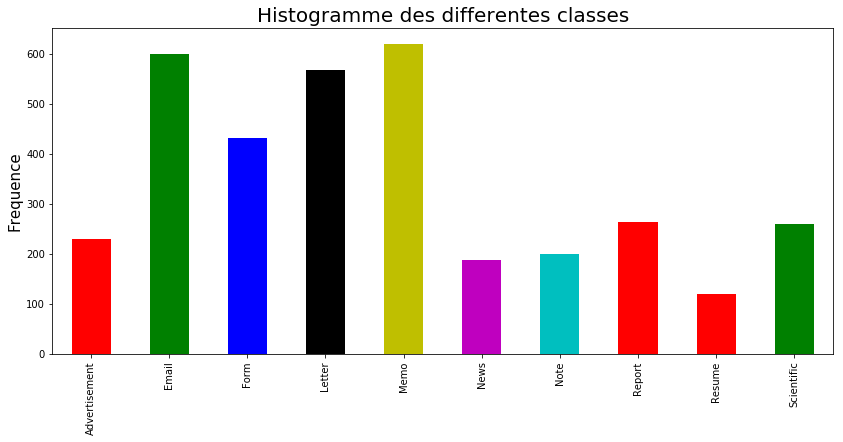

In [51]:
s = pd.Series(
    list(labels.values()),
    index = list(labels.keys())
)

plt.figure(figsize=(14,6))

plt.title('Histogramme des differentes classes', fontsize=20)
plt.ylabel('Frequence', fontsize=15)

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']

s.plot(
    kind='bar', 
    color=my_colors
)
plt.show()

- On peut remarquer que nos données sont divisées en dix classes
- Les classes Email, Form, Letter et Memo sont plus représentées que les autres classes

## Classification

### Split des données

In [69]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

### BOW puis TF-IDF

In [80]:
vectorizer = CountVectorizer(max_features=2000, max_df=0.3)
vectorizer.fit(x_train)

x_train_counts = vectorizer.transform(x_train)
x_test_counts  = vectorizer.transform(x_test)

tf_transformer = TfidfTransformer().fit(x_train_counts)
x_train_tf     = tf_transformer.transform(x_train_counts)
x_test_tf      = tf_transformer.transform(x_test_counts)

print('Entrainement : ', x_train_counts.shape)
print('Validation   : ', x_test_counts.shape)


Entrainement :  (2785, 2000)
Validation   :  (697, 2000)


In [ ]:
# MultinomialNB
model = MultinomialNB(alpha=0.05)
model.fit(x_train_tf, y_train)

In [74]:
x_test_counts.shape

(697, 2000)